라이브러리

In [8]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input, TimeDistributed
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean, cosine, correlation
from sklearn.metrics import mean_squared_error, mean_absolute_error, pairwise_distances
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_name = 'powerTest_minmax2'

데이터셋 설정

In [9]:
power = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/powerconsumption.csv")
power['Datetime'] = pd.to_datetime(power['Datetime'], format='%m/%d/%Y %H:%M', errors='raise')
power.describe()
power.set_index('Datetime', inplace=True)


In [10]:
start_date = '2017-01-01'
end_date = '2017-11-30'
power_test = power.loc[start_date:end_date]

In [11]:
start_date = '2017-12-01'
end_date = '2017-12-30'
power_validation= power.loc[start_date:end_date]

In [12]:
power_test

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
Datetime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...
2017-11-30 23:10:00,12.650,85.9,0.074,0.051,0.096,31347.69231,25705.78512,13301.20482
2017-11-30 23:20:00,12.620,86.1,0.071,0.069,0.052,30603.07692,25088.42975,13081.44578
2017-11-30 23:30:00,12.630,86.2,0.071,0.066,0.104,29889.23077,24571.48760,12740.24096


In [13]:
power_np = power_test[['Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows','PowerConsumption_Zone1']].values

print(power_np.shape)

scaler = MinMaxScaler()
X_standardized = scaler.fit_transform(power_np)

power_test = pd.DataFrame({'Datetime': power_test.index, 'Temperature': X_standardized[:, 0],'Humidity': X_standardized[:, 1],'WindSpeed': X_standardized[:, 2],'GeneralDiffuseFlows': X_standardized[:, 3],'DiffuseFlows': X_standardized[:, 4],'PowerConsumption_Zone1': X_standardized[:, 5]})
power_test.set_index('Datetime', inplace=True)

power_test

(48096, 6)


,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1
Datetime,,,,,,
2017-01-01 00:00:00,0.090091,0.757458,0.005130,0.000040,0.000115,0.526251
2017-01-01 00:10:00,0.086146,0.765947,0.005130,0.000057,0.000079,0.415545
2017-01-01 00:20:00,0.083399,0.765947,0.004663,0.000050,0.000095,0.397623
2017-01-01 00:30:00,0.078176,0.772011,0.005130,0.000075,0.000091,0.374149
2017-01-01 00:40:00,0.072736,0.780500,0.004819,0.000038,0.000079,0.350834
...,...,...,...,...,...,...
2017-11-30 23:10:00,0.255773,0.904196,0.003731,0.000040,0.000091,0.455562
2017-11-30 23:20:00,0.254957,0.906621,0.003264,0.000056,0.000044,0.436125
2017-11-30 23:30:00,0.255229,0.907834,0.003264,0.000053,0.000099,0.417491


In [14]:
# power_np = power_test[['Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows','PowerConsumption_Zone1']].values

# print(power_np.shape)

# X_standardized = scaler.inverse_transform(power_np)

# power_test = pd.DataFrame({'Datetime': power_test.index, 'Temperature': X_standardized[:, 0],'Humidity': X_standardized[:, 1],'WindSpeed': X_standardized[:, 2],'GeneralDiffuseFlows': X_standardized[:, 3],'DiffuseFlows': X_standardized[:, 4],'PowerConsumption_Zone1': X_standardized[:, 5]})
# power_test.set_index('Datetime', inplace=True)

# power_test

In [15]:
power_test_X = power_test[['Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows','PowerConsumption_Zone1']]
power_test_y = power_test[['Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows','PowerConsumption_Zone1']]

In [16]:
power_validation_X = power_validation[['Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows','PowerConsumption_Zone1']]
power_validation_y = power_validation[['Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows','PowerConsumption_Zone1']]

In [17]:
power_test_X_chunks = []
power_test_y_chunks = []

for i in range(0, len(power_test_X) - 35):
    power_test_X_chunks.append(np.array(power_test_X.iloc[i:i+36].values, dtype=np.float64))
power_test_X_chunks = np.array(power_test_X_chunks, dtype=np.float64)

for i in range(0, len(power_test_y) - 35):
    power_test_y_chunks.append(np.array(power_test_y.iloc[i:i+36].values, dtype=np.float64))
power_test_y_chunks = np.array(power_test_y_chunks, dtype=np.float64)

In [18]:
power_validation_X_chunks = []
power_validation_y_chunks = []

for i in range(0, len(power_validation_X) - 35):
    power_validation_X_chunks.append(np.array(power_validation_X.iloc[i:i+36].values, dtype=np.float64))
power_validation_X_chunks = np.array(power_validation_X_chunks, dtype=np.float64)

for i in range(0, len(power_validation_y) - 35):
    power_validation_y_chunks.append(np.array(power_validation_y.iloc[i:i+36].values, dtype=np.float64))
power_validation_y_chunks = np.array(power_validation_y_chunks, dtype=np.float64)

In [19]:
# shape확인
nCar = power_test_X_chunks.shape[0] # 데이터 개수
nVar = power_test_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = power_test_y_chunks.shape[0] # 데이터 개수
nVar = power_test_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = power_validation_X_chunks.shape[0] # 데이터 개수
nVar = power_validation_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = power_validation_y_chunks.shape[0] # 데이터 개수
nVar = power_validation_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 48061 nVar: 6
nCar: 48061 nVar: 36
nCar: 4285 nVar: 6
nCar: 4285 nVar: 36


In [20]:
power_test_X_chunks_crop = power_test_X_chunks[:-36]
power_test_y_chunks_crop = power_test_y_chunks[36:]

power_validation_X_chunks_crop = power_validation_X_chunks[:-36]
power_validation_y_chunks_crop = power_validation_y_chunks[36:]

In [21]:
# shape확인
nCar = power_test_X_chunks_crop.shape[0] # 데이터 개수
nVar = power_test_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = power_test_y_chunks_crop.shape[0] # 데이터 개수
nVar = power_test_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = power_validation_X_chunks_crop.shape[0] # 데이터 개수
nVar = power_validation_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = power_validation_y_chunks_crop.shape[0] # 데이터 개수
nVar = power_validation_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

power_test_y_chunks_crop.shape

nCar: 48025 nVar: 6
nCar: 48025 nVar: 36
nCar: 4249 nVar: 6
nCar: 4249 nVar: 36


(48025, 36, 6)

In [22]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

In [23]:
# LSTM 모델 생성
model = Sequential()
model.add(LSTM(128, input_shape=(36, 6), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(TimeDistributed(Dense(6, activation='linear')))
 
model.summary()

model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])

checkpoint = ModelCheckpoint(model_name+'.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

hist = model.fit(power_test_X_chunks_crop, power_test_y_chunks_crop, epochs = 1000, batch_size = 36, validation_data=(power_validation_X_chunks_crop, power_validation_y_chunks_crop), callbacks=[checkpoint, early_stop, reduce_lr])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 36, 128)           69120     
                                                                 
 lstm_1 (LSTM)               (None, 36, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 36, 32)            12416     
                                                                 
 time_distributed (TimeDistr  (None, 36, 6)            198       
 ibuted)                                                         
                                                                 
Total params: 131,142
Trainable params: 131,142
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1335/1335 [==============================] - 59s 40ms/step - loss: 0.0206 - mae: 0.0947 - r_squared: 0.

In [105]:
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[ 0.10977114  0.1862649  -0.07833567 ...  0.41492286  0.09354678
   0.18244576]
 [ 0.08336287  0.25963598 -0.05710785 ...  0.0673179  -0.01041968
   0.0724268 ]
 [ 0.06780753  0.18966708  0.04016047 ...  0.11362032  0.02743408
   0.25493988]
 [-0.02632543 -0.05933781 -0.09678626 ...  0.19453795  0.2517116
   0.03442952]
 [ 0.02454711  0.03734189  0.0086833  ... -0.19853614  0.16263671
   0.20069662]
 [-0.20271468  0.02638899 -0.19734868 ...  0.12811247 -0.03452569
   0.24722232]]


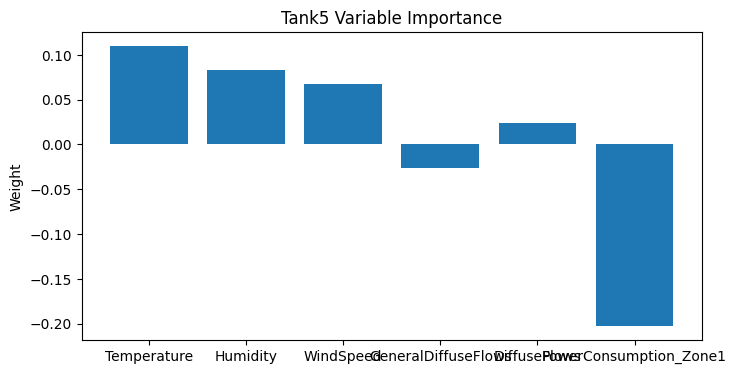

In [24]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(6), weights[:, 0])
ax.set_xticks(range(6))
ax.set_xticklabels(['Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows','PowerConsumption_Zone1'])
ax.set_ylabel('Weight')
ax.set_title('Tank5 Variable Importance')
plt.show()

In [25]:
# 모델 평가 함수
def grapeNEva(X_test_shape, y_test, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = X_pred.reshape(-1, X_pred.shape[-1])
    print("###### \n", X_pred.shape)
    X_pred = scaler.inverse_transform(X_pred)
    print("###### \n", X_pred)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.T
    print(X_pred)

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test['PowerConsumption_Zone1'], label='power')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred[5], label='prediction')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('power')
    plt.title('test')
    plt.legend(['power','prediction'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [26]:
X_test = power_validation_X.loc['2017-12-01 00:00':'2017-12-30 17:50']
X_test_scaled = scaler.transform(X_test)
X_test_reshape = np.asarray(X_test_scaled, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 36, 6))
print(X_test_reshape.shape)

(119, 36, 6)


c:\Users\rladn\anaconda3\envs\doRegressor\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [27]:
y_test = power_validation_y.loc['2017-12-01 06:00':'2017-12-30 23:50']

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 36, 6))

print(y_test.shape)
print(y_test_reshape.shape)

(4284, 6)
(119, 36, 6)


4/4 [==============================] - 1s 15ms/step
###### 
 (4284, 6)
###### 
 [[1.67657928e+01 5.90408745e+01 4.01512027e-01 2.04159714e+02
  9.09025497e+01 2.89875430e+04]
 [1.84613724e+01 5.95647469e+01 2.79005408e-01 1.87420990e+02
  9.75708466e+01 2.84424062e+04]
 [1.84704094e+01 6.04751015e+01 3.68888408e-01 1.98698837e+02
  1.01604027e+02 2.75005312e+04]
 ...
 [1.16962852e+01 5.59639130e+01 1.25545099e-01 1.67984505e+01
  6.64306581e-01 2.98113711e+04]
 [1.17721081e+01 5.62358856e+01 1.22745246e-01 2.52213554e+01
  4.94861031e+00 2.91703027e+04]
 [1.15905581e+01 5.85036812e+01 1.17977306e-01 2.25223923e+01
  1.17707980e+00 2.83894316e+04]]
[[1.67657928e+01 1.84613724e+01 1.84704094e+01 ... 1.16962852e+01
  1.17721081e+01 1.15905581e+01]
 [5.90408745e+01 5.95647469e+01 6.04751015e+01 ... 5.59639130e+01
  5.62358856e+01 5.85036812e+01]
 [4.01512027e-01 2.79005408e-01 3.68888408e-01 ... 1.25545099e-01
  1.22745246e-01 1.17977306e-01]
 [2.04159714e+02 1.87420990e+02 1.98698837e+02 

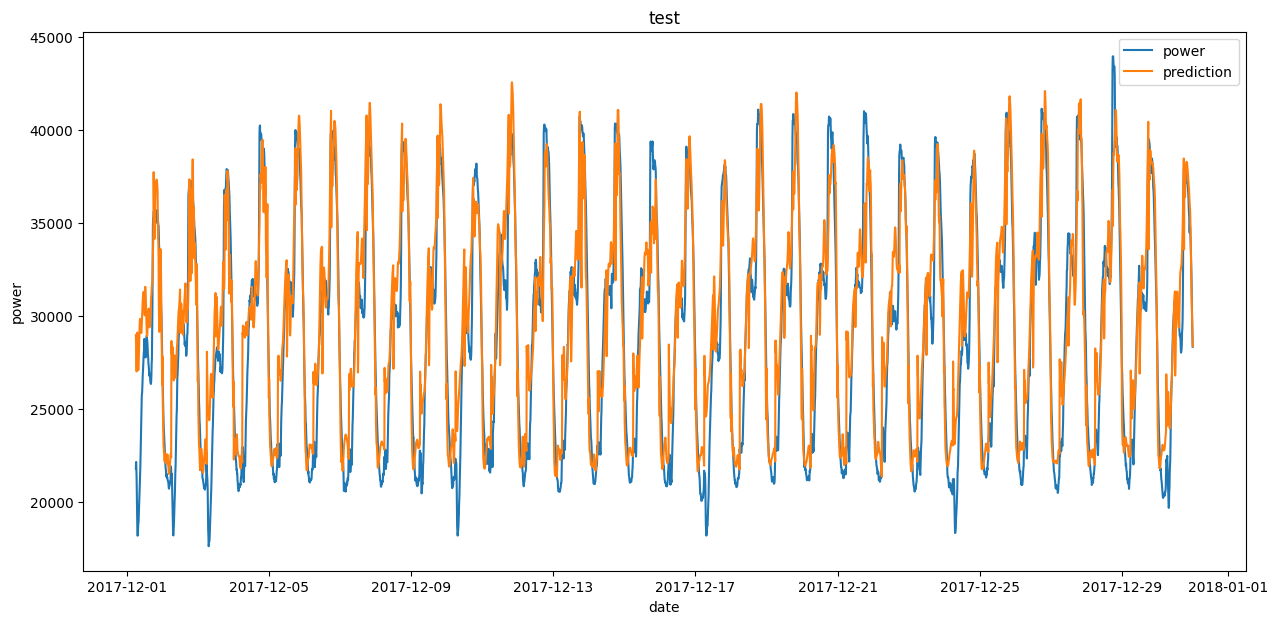

4/4 [==============================] - 0s 27ms/step - loss: 147263104.0000 - mae: 4882.0820 - r_squared: -0.1932
MSE // MAE // R-squared  [147263104.0, 4882.08203125, -0.19316935539245605]


In [28]:
grapeNEva(X_test_reshape, y_test, y_test_reshape)

nCar: 7 nVar: 36
nCar: 252 nVar: 6
nCar: 7 nVar: 36
1/1 [==============================] - 0s 32ms/step


c:\Users\rladn\anaconda3\envs\doRegressor\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


###### 
 (252, 6)
###### 
 [[1.6765793e+01 5.9040874e+01 4.0151203e-01 2.0415971e+02 9.0902550e+01
  2.8987543e+04]
 [1.8461372e+01 5.9564747e+01 2.7900541e-01 1.8742099e+02 9.7570847e+01
  2.8442406e+04]
 [1.8470409e+01 6.0475101e+01 3.6888841e-01 1.9869884e+02 1.0160403e+02
  2.7500531e+04]
 ...
 [1.3596453e+01 6.9652397e+01 2.3588571e-01 2.7435055e+01 1.8200296e+01
  2.9696150e+04]
 [1.2925960e+01 7.0078690e+01 3.1164974e-01 2.4874306e+01 1.3373187e+01
  2.7608277e+04]
 [1.2537364e+01 7.0831451e+01 3.2594791e-01 1.3495363e+01 8.4605885e+00
  2.6475025e+04]]
[[1.67657928e+01 1.84613724e+01 1.84704094e+01 ... 1.35964527e+01
  1.29259596e+01 1.25373640e+01]
 [5.90408745e+01 5.95647469e+01 6.04751015e+01 ... 6.96523972e+01
  7.00786896e+01 7.08314514e+01]
 [4.01512027e-01 2.79005408e-01 3.68888408e-01 ... 2.35885710e-01
  3.11649740e-01 3.25947911e-01]
 [2.04159714e+02 1.87420990e+02 1.98698837e+02 ... 2.74350548e+01
  2.48743057e+01 1.34953632e+01]
 [9.09025497e+01 9.75708466e+01 1.016

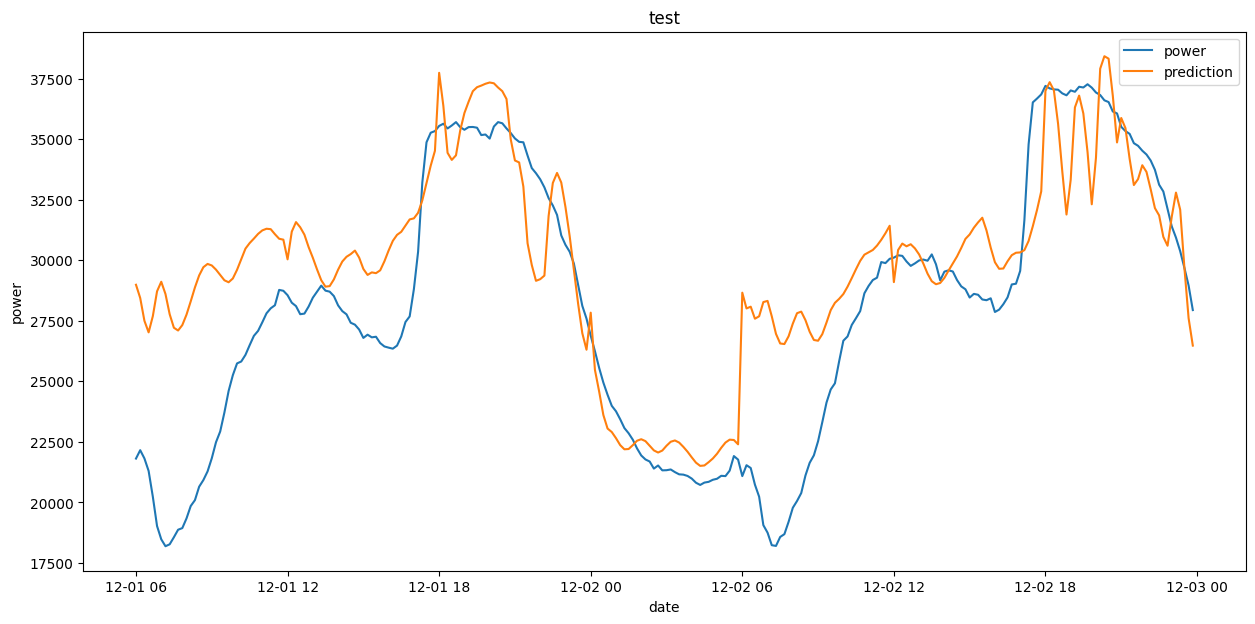

1/1 [==============================] - 0s 34ms/step - loss: 135675488.0000 - mae: 4703.7471 - r_squared: -0.1948
MSE // MAE // R-squared  [135675488.0, 4703.7470703125, -0.19483542442321777]


In [29]:
X_test = power_validation_X.loc['2017-12-01 00:00':'2017-12-02 17:50']
X_test_scaled = scaler.transform(X_test)
X_test_reshape = np.asarray(X_test_scaled, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 36, 6))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

y_test = power_validation_y.loc['2017-12-01 06:00':'2017-12-02 23:50']

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 36, 6))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva(X_test_reshape, y_test, y_test_reshape)